In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import glob
from scipy.interpolate import interp1d
import sys
sys.path.append("./")
from env_list.simple2d import Simple2D, Sargolini2006, Hafting2008

In [2]:
def get_2D_ratemap(time_array, spikes, x, y, x_size=50, y_size=50):
    x_spikes, y_spikes = [], []
    for s in spikes:
        array_pos = np.argmin(np.abs(time_array-s))
        x_spikes.append(x[array_pos])
        y_spikes.append(y[array_pos])
    x_spikes = np.array(x_spikes)
    y_spikes = np.array(y_spikes)
    h, binx, biny = np.histogram2d(x_spikes, y_spikes, bins=(x_size, y_size))
    return h.T, binx, biny

In [3]:
def clean_data(data, keep_headers=False):
    # print(list(data.keys()))
    aux_dict = {}
    for key, val in data.items():
        if isinstance(val, bytes) or isinstance(val, str) or key=="__globals__":
            if keep_headers:
                aux_dict[key] = val
            continue
        else:
            if np.isnan(val).any():
                aux_dict[key] = val
            else:
                # Interpolate nans
                x_range = np.linspace(0, 1, num=len(val))
                nan_indexes = np.logical_not(np.isnan(val))[:, 0]
                clean_x = x_range[nan_indexes]
                clean_val = np.array(val)[nan_indexes, 0]
                f = interp1d(clean_x, clean_val, kind='cubic')
                aux_dict[key] = f(x_range)
    return aux_dict

In [4]:
data_path = "experiment_data/Hafting2008/C43035A4-5CC5-44F2-B207-126922523FD9_1/"

data_path_list = glob.glob(data_path+"*.mat")

#The naming convention for the files is as follow
#Rat number - session number - file type (i.e: 11015-13120410_EEG)
mice_ids = np.unique([dp.split("/")[-1][:5] for dp in data_path_list])
session_per_animal = {}
cell_id_per_session = {}
for m_id in mice_ids:
    print(mice_ids)
    m_paths_list = glob.glob(data_path + m_id + "*.mat")
    sessions = np.unique([dp.split("/")[-1].split("-")[1][:8]  for dp in m_paths_list]).astype(str)
    session_per_animal[m_id] = {}
    for sess in sessions:
        s_paths_list = glob.glob(data_path + m_id + "-" + sess + "*.mat")
        cell_ids = np.unique([dp.split("/")[-1].split(".")[-2][-4:] for dp in s_paths_list]).astype(str)
        session_per_animal[m_id][sess] = {}
        for cell_id in cell_ids:
            r_path = s_paths_list = glob.glob(data_path + m_id + "-" + sess + "*" + cell_id + "*.mat")
            cleaned_data = clean_data(sio.loadmat(r_path[0]))
            session_per_animal[m_id][sess][cell_id] = cleaned_data
#Here we record for a specifique mice
recording_paths = sorted(glob.glob(data_path+mice_ids[0]+"-*.mat"))



['11015' '11265' '11340' '11343' '11607' '11647' '11684']
['11015' '11265' '11340' '11343' '11607' '11647' '11684']
['11015' '11265' '11340' '11343' '11607' '11647' '11684']
['11015' '11265' '11340' '11343' '11607' '11647' '11684']
['11015' '11265' '11340' '11343' '11607' '11647' '11684']
['11015' '11265' '11340' '11343' '11607' '11647' '11684']
['11015' '11265' '11340' '11343' '11607' '11647' '11684']


In [5]:
mouse_data = {}
for r_path in recording_paths:
    trial_id = r_path.split(".")[0][-4:]
    print(trial_id)
    mouse_data[trial_id] = sio.loadmat(r_path)

_EEG
_POS
t5c1


In [6]:
best_session = {"rat": "11015", "sess": "13120410", "cell_id": "t5c1"}

[154.46702497 154.46702497 154.46702497 ... -94.44296782 -90.13491026
 -90.13491026]
[ 3.58106033  3.58106033  4.53840645 ... -0.24832418 -0.72699724
 -0.72699724]
[0.0000e+00 2.0000e-02 4.0000e-02 ... 5.9994e+02 5.9996e+02 5.9998e+02]
[  8.71960417   8.72342708   8.73361458 ... 599.398875   599.52916667
 599.53541667]


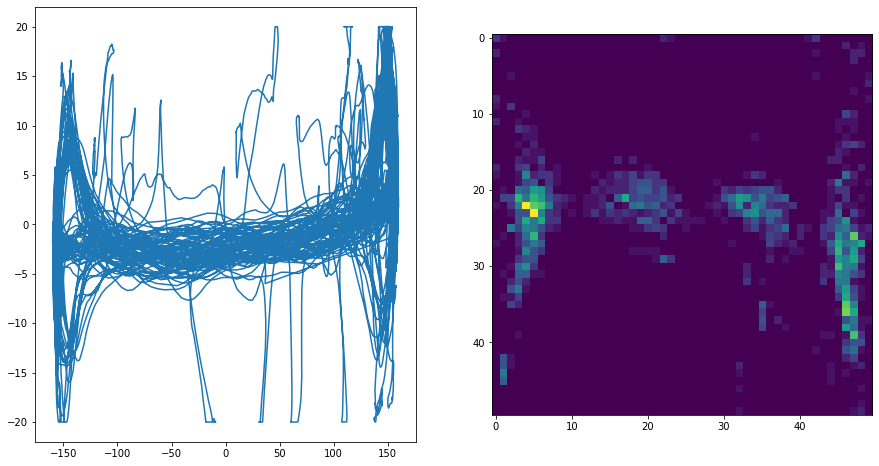

In [7]:
cell_data = session_per_animal[best_session["rat"]][best_session["sess"]]
first_cell_data = list(cell_data.values())[1]
x1, y1 = first_cell_data["posx"][:], first_cell_data["posy"][:]
# Selecting positional data
x = np.clip(x1, a_min=-200, a_max=200)
y = np.clip(y1, a_min=-20, a_max=20)

time_array = first_cell_data["post"][:]
first_cell_data = list(cell_data.values())[2]

test_spikes = first_cell_data["ts"][:]

f, ax = plt.subplots(1, 2, figsize=(15, 8))
ax = ax.flatten()
ax[0].plot(x, y)
print(x)
print(y)
print(time_array)
print(test_spikes)
h, binx, biny = get_2D_ratemap(time_array, test_spikes, x, y)
ax[1].imshow(h)
plt.show()


These cells are from layers II and III of medial entorhinal cortex and have  been published in Hafting et al. (Nature, 2008). 

The files are in matlab format. They include spike and position times for a number of simultaneously recorded cells from rats that were running on a linear track (mostly 320 cm).
The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex. 

The cell id is based on tetrode number and cell number (i.e: t2c7).

The EEG file is included to enable analyses of theta phase relationships etc.


There are 3 file types available for each recording: EEG data, Position data and Spike data.

The naming convention for the files is as follow

Rat number - session number - file type (i.e: 11015-13120410_EEG)

The spike data file has the cell id as the file type (i.e: 11015-13120410_t5c1).


Each session duration is normally 10 minutes, but some sessions combine 2 or more 10 minutes sessions, this is marked in 
the file name by using "+" between the

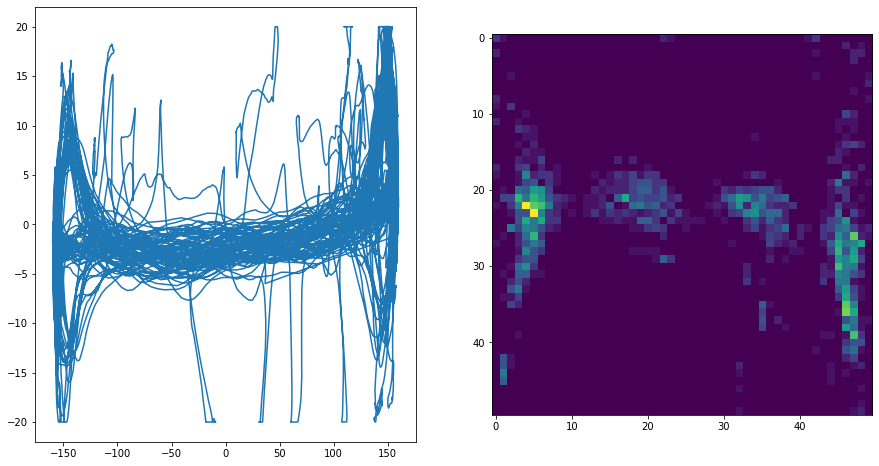

AttributeError: 'FullHaftingData' object has no attribute 'position'

In [8]:
data_path = "experiment_data/Hafting2008/C43035A4-5CC5-44F2-B207-126922523FD9_1/"
session = {"rat": "11015", "sess": "13120410", "cell_id": "t5c1"}

env =  Hafting2008(data_path = data_path,
                    verbose = True,
                    session = session,
                    time_step_size = None, agent_step_size = None)